In [1]:
from matplotlib import pyplot as plt
from datetime import datetime
import math
import sys
from pprint import pprint

sys.path.append('../..')
from model.processing import query_sqlPad
time_range = ('2024-6-15T00:00:00.000Z', '2024-6-18T00:00:00.000Z')
tkn = 'DOT'
binance_tkn = 'DOT'

In [2]:
query = f"""
WITH normalized_trades AS (
  SELECT
    timestamp,
    block,
    who,
    operation,
    (SELECT symbol FROM token_metadata WHERE id = asset_in LIMIT 1) AS asset_in,
    (SELECT symbol FROM token_metadata WHERE id = asset_out LIMIT 1) AS asset_out,
    amount_in / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_in LIMIT 1)) AS amount_in,
    amount_out / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_out LIMIT 1)) AS amount_out,
    asset_fee_amount / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_out LIMIT 1)) AS asset_fee_amount,
    lrna_in / POWER(10, 12) as lrna_in,
    lrna_out / POWER(10, 12) as lrna_out,
    lrna_fee_amount / POWER(10, 12) as lrna_fee_amount,
    lrna_fee_amount / NULLIF(lrna_out, 0) as lrna_fee_rate,
    asset_fee_amount / NULLIF(amount_out, 0) as asset_fee_rate
  FROM (
    SELECT
      timestamp,
      block.height AS block,
      args->>'who' AS who,
      name AS operation,
      (args->>'assetIn')::integer AS asset_in,
      (args->>'assetOut')::integer AS asset_out,
      (args->>'amountIn')::numeric AS amount_in,
      (args->>'amountOut')::numeric AS amount_out,
      (args->>'hubAmountIn')::numeric as lrna_out,
      (args->>'hubAmountOut')::numeric as lrna_in,
      (args->>'assetFeeAmount')::numeric as asset_fee_amount,
      (args->>'protocolFeeAmount')::numeric as lrna_fee_amount
    FROM event
    INNER JOIN block ON block_id = block.id
    WHERE name LIKE 'Omnipool.%Executed'
      AND "timestamp" BETWEEN '{time_range[0]}' AND '{time_range[1]}'
  ) AS trades
),
trades AS (
  SELECT
    timestamp,
    block,
    amount_out as amount,
    lrna_in as lrna,
    (amount_out + asset_fee_amount) / NULLIF(lrna_in + lrna_fee_amount, 0) as price,
    asset_fee_rate as fee_rate,
    'asset' as fee_type,
    'sell' as direction,
    asset_in as other_asset
  FROM normalized_trades
  WHERE asset_out = '{tkn}'
  UNION ALL
  SELECT
    timestamp,
    block,
    amount_in as amount,
    lrna_out as lrna,
    amount_in / (lrna_out + lrna_fee_amount) as price,
    lrna_fee_rate as fee_rate,
    'LRNA' as fee_type,
    'buy' as direction,
    asset_out as other_asset
  FROM normalized_trades
  WHERE asset_in = '{tkn}'
)
SELECT
  block,
  amount,
  lrna,
  price,
  fee_rate,
  fee_type,
  direction,
  other_asset,
  timestamp
FROM trades 
ORDER BY 1;
"""

In [3]:
trades_history = query_sqlPad(query)
# last_trade = trades_history[0]
# trades_history = [
#     last_trade := [*trade, trade[3] - last_trade[3]] 
#     for trade in trades_history 
#     if trade[3] != None
# ]
print("done")

waiting for query to finish...
done


In [4]:
# trades_history = trades_history[:2377] + [[
#     5348832,
#     428.5207716843,
#     73.606616694355,
#     5.729923847804615,
#     '0.00273546234263028916',
#     'asset',
#     'buy',
#     '4-Pool',
#     '2024-06-16T16:31:42.000Z'
# ]] + trades_history[2377:]

In [5]:
def fill_blocks(data, index, first_block: int = None, last_block: int = None):
    relevant_data = {line[0]: float(line[index]) for line in data if line[index] is not None}
    min_block = min(relevant_data)
    if first_block is None:
        first_block = min_block
    elif first_block < min_block:
        relevant_data.update({block: relevant_data[min_block] for block in range(first_block, min_block)})
        
    max_block = max(relevant_data)
    if last_block is None:
        last_block = max_block
    elif last_block > max_block:
        relevant_data.update({block: relevant_data[max_block] for block in range(max_block, last_block)})
    
    last_item = None
    return [relevant_data.get(block, last_item := relevant_data.get(block, last_item)) for block in range(first_block, last_block + 1)]

def oraclize(raw_data, length = 10):
    decay_factor = 2 / (length + 1)
    oracle_current = raw_data[0]
    oracle_values = [oracle_current]
    for item in raw_data[1:]:
        oracle_current = oracle_current * (1 - decay_factor) + item * decay_factor
        oracle_values.append(oracle_current)
    return oracle_values

In [6]:
min_block = trades_history[0][0]
max_block = trades_history[-1][0]
lrna_fees = fill_blocks(filter(lambda x: x[5] == 'LRNA', trades_history), 4, min_block, max_block)
asset_fees = fill_blocks(filter(lambda x: x[5] == 'asset', trades_history), 4, min_block, max_block)
tkn_prices = [1 / price for price in fill_blocks(trades_history, 3)]
blocks = list(range(min_block, max_block + 1))

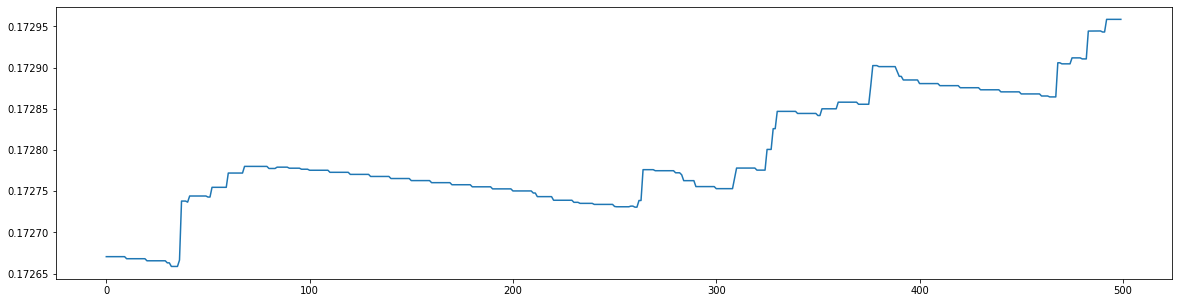

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(tkn_prices[10500: 11000])

In [8]:
# get recorded market prices for the given time range
from model.processing import import_binance_prices, get_historical_omnipool_balance
start_date=datetime.strptime(time_range[0], '%Y-%m-%dT%H:%M:%S.%fZ')
end_date=datetime.strptime(time_range[1], '%Y-%m-%dT%H:%M:%S.%fZ')
historical_price_data = import_binance_prices(
    assets=[binance_tkn],
    start_date=datetime.strftime(start_date, "%B %d %Y"),
    days=math.ceil((end_date - start_date).total_seconds() / (24 * 60 * 60))
)

In [9]:
tkn_liquidity = get_historical_omnipool_balance(tkn, time_range[0])  # 2319659
tkn_lrna = tkn_liquidity * tkn_prices[0]

liquidity_history = [[min_block, tkn_liquidity]]
lrna_history = [[min_block, tkn_lrna]]

for trade in trades_history:
    liquidity_history.append([
        trade[0], liquidity_history[-1][1]
        - (trade[1] if trade[6] == 'sell' else -trade[1])
    ])
    lrna_history.append([
        trade[0], lrna_history[-1][1]
        - (trade[2] if trade[6] == 'buy' else -trade[2])
    ])
liquidity_history = fill_blocks(liquidity_history, 1, min_block, max_block)
lrna_history = fill_blocks(lrna_history, 1, min_block, max_block)
spot_price_history = [lrna_history[i] / liquidity_history[i] for i in range(len(blocks))]

loading omnipool_history_047.json
Retrieved balance of DOT on 2024-06-15: 2196333.872072789


21333


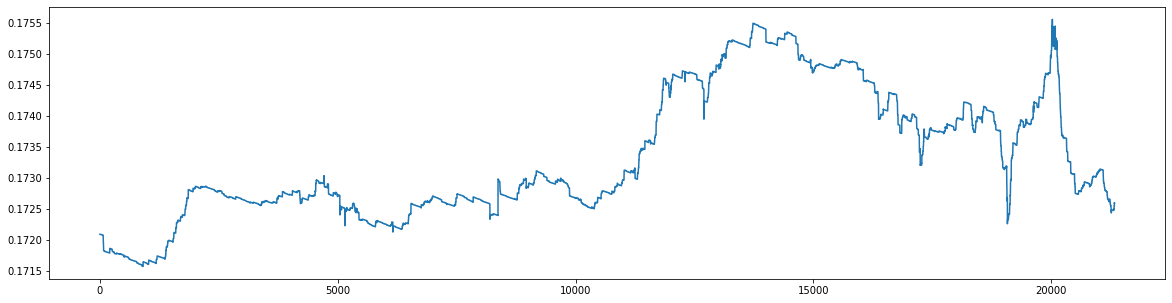

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(spot_price_history)
print(len(spot_price_history))

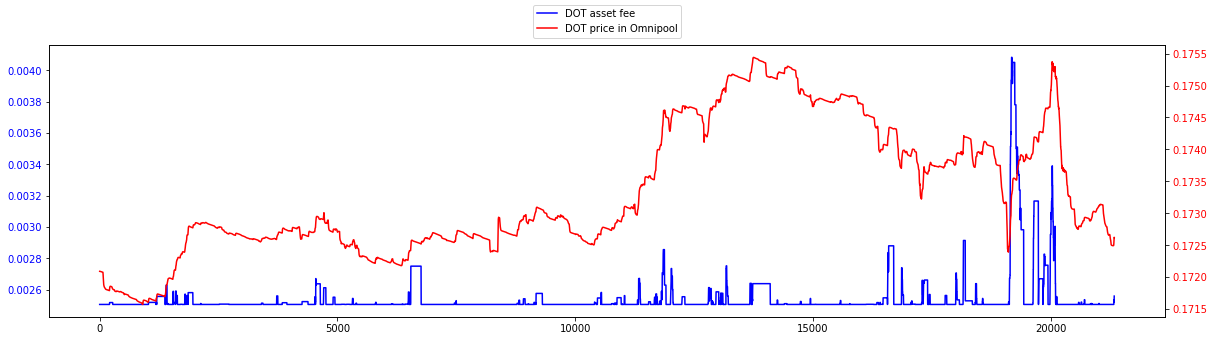

In [11]:
view_range = (0, len(blocks))
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.tick_params(axis='y', labelcolor="blue")
ax.plot(asset_fees[view_range[0]: view_range[1]], color='blue', label=f"{tkn} asset fee")
ax2 = ax.twinx()
ax2.plot(oraclize(tkn_prices[view_range[0]: view_range[1]]), color='red', label=f"{tkn} price in Omnipool")
ax2.tick_params(axis='y', labelcolor="red")
fig.legend(loc="upper center")
plt.show()

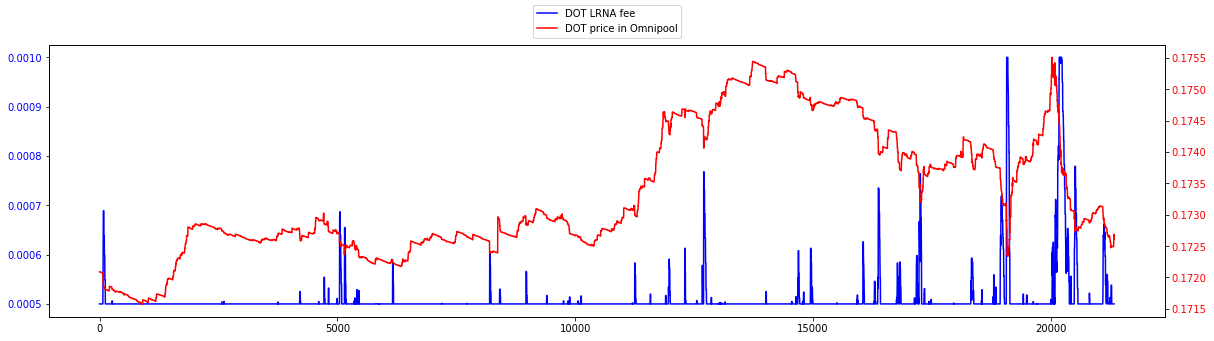

In [12]:
view_range = (0, len(blocks))
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.tick_params(axis='y', labelcolor="blue")
ax.plot(lrna_fees[view_range[0]: view_range[1]], color='blue', label=f"{tkn} LRNA fee")
ax2 = ax.twinx()
ax2.plot(tkn_prices[view_range[0]: view_range[1]], color='red', label=f"{tkn} price in Omnipool")
ax2.tick_params(axis='y', labelcolor="red")
fig.legend(loc='upper center')
plt.show()

In [13]:
# get actual balance history from the time range, which accounts for add/remove liquidity operations not captured in the data we have so far

balance_history = get_historical_omnipool_balance(tkn, date=trades_history[0][8], end_date=trades_history[-1][8])
timestamps = [trade[8] for trade in trades_history]
# print(len([(date, balance) for date, balance in balance_history.items() if date not in timestamps]))
balances = []
for date, balance in balance_history.items():
    i = timestamps.index(date) if date in timestamps else -1
    if i >= 0:
        trade = trades_history[i]
        balances.append((trade[0], balance))
balances = fill_blocks(balances, 1, min_block, max_block)
print('Matched blocks to existing dataset.')

loading omnipool_history_047.json
Retrieved balance of DOT from 2024-06-15 - 2024-06-18.
Matched blocks to existing dataset.


In [37]:
# simulate with same trades and see if it comes out the same
from model.amm.omnipool_amm import OmnipoolState, dynamicadd_asset_fee, dynamicadd_lrna_fee, usd_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices
from model.amm.oracle import Block
from datetime import datetime
import math
import random

lrna_fee_amplification=1.0
lrna_fee_decay=0.000005
lrna_fee_min=0.0005
lrna_fee_max=0.001
asset_fee_amplification=2.0
asset_fee_decay=0.00001
asset_fee_min=0.0025
asset_fee_max=0.05


initial_omnipool_tvl = 10000000
lrna_price_usd = tkn_prices[0] * historical_price_data[0][binance_tkn]

class ProdOmnipool(OmnipoolState):
    def update(self):
        # update oracles
        self.current_block.price['HDX'] = self.lrna['HDX'] / self.liquidity['HDX']

        for name, oracle in self.oracles.items():
            oracle.update(self.current_block)

        # update current block
        self.time_step += 1
        self.current_block = Block(self)

        # update fees
        self.last_fee = {tkn: max(self.last_fee[tkn] - asset_fee_decay, asset_fee_min) for tkn in self.asset_list}
        self.last_lrna_fee = {tkn: max(self.last_lrna_fee[tkn] - lrna_fee_decay, lrna_fee_min) for tkn in self.asset_list}

        self.fail = ''
        if self.update_function:
            self.update_function(self)

        return self
    
    def swap(self, **kwargs):
        tkn_buy = kwargs['tkn_buy']
        tkn_sell = kwargs['tkn_sell']
        if self.time_step == blocks[2]: print(tkn_buy, tkn_sell)
        if tkn_buy in self.asset_fee: self.asset_fee[tkn_buy].compute()
        if tkn_buy in self.lrna_fee: self.lrna_fee[tkn_buy].compute()
        if tkn_sell in self.asset_fee: self.asset_fee[tkn_sell].compute()
        if tkn_sell in self.lrna_fee: self.lrna_fee[tkn_sell].compute()
        super().swap(**kwargs)
        
        
omnipool = ProdOmnipool(
    tokens={
        tkn: {'liquidity': tkn_liquidity, 'LRNA': tkn_lrna},
        'HDX': {'liquidity': 100000000, 'LRNA': 100000000 / 0.01 / lrna_price_usd},
        'USD': {'liquidity': 10000000, 'LRNA': 10000000 / lrna_price_usd}
    },
    lrna_fee=dynamicadd_lrna_fee(
        minimum=lrna_fee_min,
        amplification=lrna_fee_amplification,
        raise_oracle_name='price',
        decay=lrna_fee_decay,
        fee_max=lrna_fee_max,
    ),
    asset_fee=dynamicadd_asset_fee(
        minimum=asset_fee_min,
        amplification=asset_fee_amplification,
        raise_oracle_name='price',
        decay=asset_fee_decay,
        fee_max=asset_fee_max,
    ),
    oracles={'price': 9},
    preferred_stablecoin = 'USD',
)

initial_state = GlobalState(
    pools={
        'omnipool': omnipool
    },
    agents={
        'trader': Agent(
            holdings={tkn: 1000000000 for tkn in ['HDX', tkn, 'USD', 'LRNA']}
        )
    }
)

In [38]:
print('simulating')
events = []
simulated_sell_fees = []
simulated_buy_fees = []
simulated_fees = []
simulate_state = initial_state.copy()
simulate_state.pools['omnipool'].lrna_fee_this_block = {tkn: 0, 'HDX': 0, 'USD': 0}
simulate_state.pools['omnipool'].asset_fee_this_block = {tkn: 0, 'HDX': 0, 'USD': 0}
omnipool = simulate_state.pools['omnipool']
trade_index = 0
print_window = [12020, 12080]
for i, block in enumerate(blocks):
    update = True
    omnipool.time_step = int(block)
    while trade_index < len(trades_history) and trades_history[trade_index][0] == block:
        # omnipool.asset_fee[tkn].compute()
        trade = trades_history[trade_index]
        amount = trade[1]
        lrna = trade[2]
        price = trade[3]
        trade_type = trade[6]
        omnipool.swap(
            agent=simulate_state.agents['trader'],
            tkn_sell=tkn if trade_type == 'buy' else 'LRNA',
            tkn_buy=tkn if trade_type == 'sell' else 'LRNA',
            sell_quantity = amount if trade_type == 'buy' else 0,
            buy_quantity = amount if trade_type == 'sell' else 0,
        )
        # account for liquidity changes not captured by the query
        # this should be pretty accurate because add/remove liquidity doesn't change the spot price
        liquidity = balances[i]
        lrna = liquidity * spot_price_history[i]
        omnipool.lrna[tkn], omnipool.liquidity[tkn] = lrna, liquidity
        trade_index += 1
        if trade_type == 'sell':
            update = True
            simulated_sell_fees.append([block, simulate_state.pools['omnipool'].last_fee[tkn]])
        elif trade_type == 'buy':
            simulated_buy_fees.append([block, simulate_state.pools['omnipool'].last_fee[tkn]])
        simulated_fees.append([block, omnipool.last_fee[tkn]])
    omnipool.update()
#     for tkn in omnipool.asset_list:
#         omnipool.last_fee[tkn] -= asset_fee_decay
#         omnipool.last_fee[tkn] = max(omnipool.last_fee[tkn], asset_fee_min)
#     omnipool.oracles['price'].update(omnipool.current_block)
#     omnipool.current_block.volume_in = {tkn: 0 for tkn in omnipool.asset_list}
#     omnipool.current_block.volume_out = {tkn: 0 for tkn in omnipool.asset_list}
            
    simulate_state.time_step = int(block)
    events.append(simulate_state.archive())

simulated_sell_fees = fill_blocks(simulated_sell_fees, 1, min_block, max_block)
simulated_buy_fees = fill_blocks(simulated_buy_fees, 1, min_block, max_block)
simulated_fees = fill_blocks(simulated_fees, 1, min_block, max_block)
print('done')

simulating
done


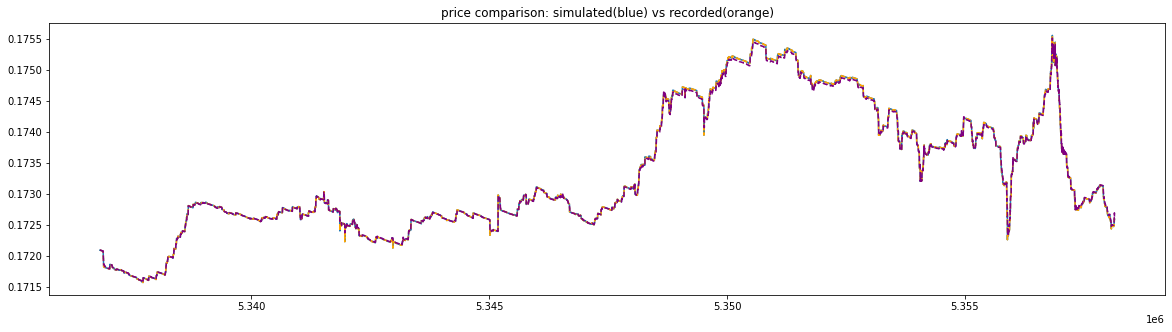

In [39]:
plt.figure(figsize=(20, 5))
# view_range = (10400, 10410)
# view_range = (12000, 12500)
view_range = (0, len(blocks))
# view_range = (0, len(blocks))
plt.plot(blocks[view_range[0]: view_range[1]], [event.pools['omnipool'].lrna[tkn] / event.pools['omnipool'].liquidity[tkn] for event in events[view_range[0]: view_range[1]]])
plt.plot(blocks[view_range[0]: view_range[1]], spot_price_history[view_range[0]: view_range[1]], color='orange', linestyle='--')
plt.plot(blocks[view_range[0]: view_range[1]], tkn_prices[view_range[0]: view_range[1]], color='purple', linestyle='--')
plt.title('price comparison: simulated(blue) vs recorded(orange)')
plt.show()

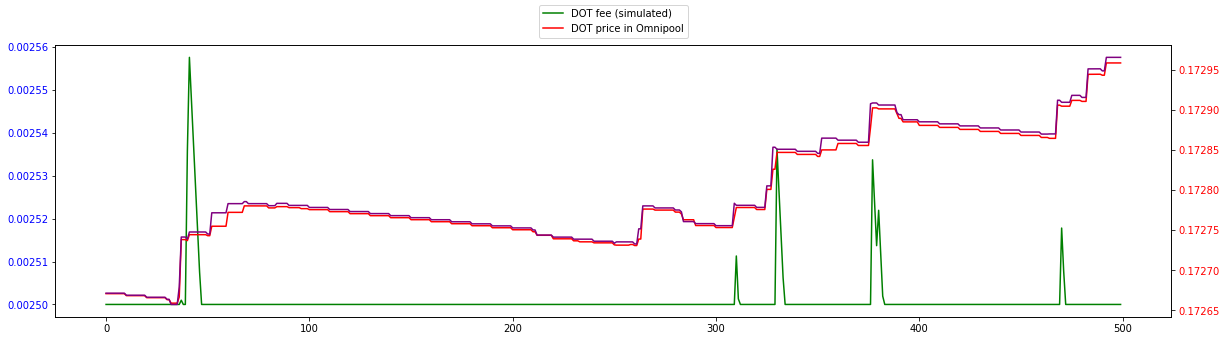

In [40]:
view_range = (10500, 11000)
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.tick_params(axis='y', labelcolor="blue")
# ax.plot(asset_fees[view_range[0]: view_range[1]], color='blue', label=f"{tkn} fee")
ax.plot([event.pools['omnipool'].last_fee[tkn] for event in events[view_range[0]: view_range[1]]], color='green', label = f"{tkn} fee (simulated)")
ax2 = ax.twinx()
ax2.plot(tkn_prices[view_range[0]: view_range[1]], color='red', label=f"{tkn} price in Omnipool")
ax2.plot(spot_price_history[view_range[0]: view_range[1]], color='purple')
ax2.tick_params(axis='y', labelcolor="red")
fig.legend(loc='upper center')
plt.show()

In [41]:
active_blocks = [block[0] for block in trades_history]
# active_block_fees = fill_blocks(
#     [[event.time_step + 1, event.pools['omnipool'].last_fee[tkn]] for event in events if event.time_step + 1 in active_blocks],
#     1, min_block, max_block
# )

In [42]:
# try and simulate what the fees should be, based on oracles
next_fee = asset_fees[0]
calculated_fees = [
    next_fee := min(max(next_fee + (
        event.pools['omnipool'].oracles['price'].volume_out[tkn]
        - event.pools['omnipool'].oracles['price'].volume_in[tkn]
    ) / event.pools['omnipool'].oracles['price'].liquidity[tkn] 
    * (asset_fee_amplification if event.time_step in active_blocks else 0)
    - asset_fee_decay, asset_fee_min), asset_fee_max)
    for event in events
]
sell_blocks = [block[0] for block in list(filter(lambda x: x[6] == 'sell', trades_history))]
projected_fees = fill_blocks([(event.time_step, calculated_fees[i]) for i, event in enumerate(events) if event.time_step in active_blocks], 1, min_block, max_block)

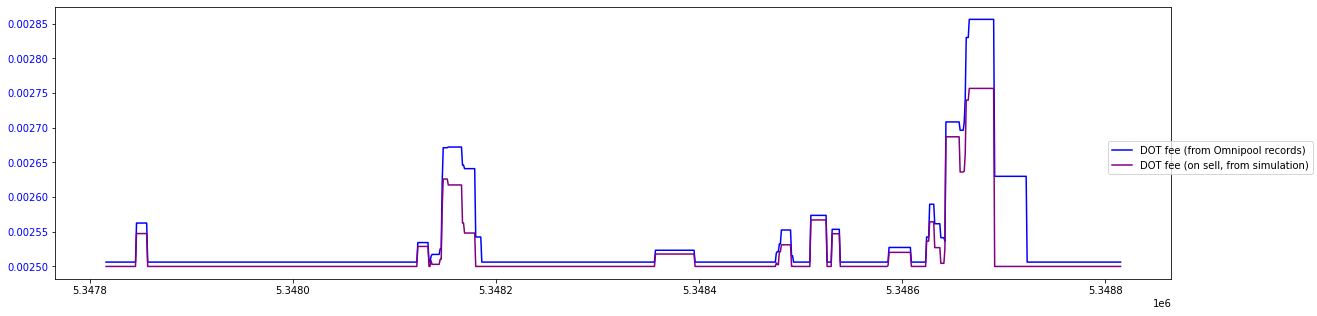

In [43]:
view_range = (11000, 12000)
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.tick_params(axis='y', labelcolor="blue")
ax.plot(blocks[view_range[0]: view_range[1]], asset_fees[view_range[0]: view_range[1]], color='blue', label=f"{tkn} fee (from Omnipool records)")
ax.plot(blocks[view_range[0]: view_range[1]], simulated_sell_fees[view_range[0]: view_range[1]], color='purple', label = f"{tkn} fee (on sell, from simulation)")
# ax.plot(blocks[view_range[0]: view_range[1]], projected_fees[view_range[0]: view_range[1]], color='green', label = f"{tkn} fee (continuous, calculated)")
# ax.plot(blocks[view_range[0]: view_range[1]], [event.pools['omnipool'].last_fee[tkn] for event in events[view_range[0]: view_range[1]]], color='orange', linestyle='--')
# ax.plot(blocks[view_range[0]: view_range[1]], active_block_fees[view_range[0]: view_range[1]], color='orange', label = f"{tkn} fee (adjusted)", linestyle='--')
# ax.plot(blocks[view_range[0]: view_range[1]], adjusted_active_block_fees[view_range[0]: view_range[1]], color='teal', label = f"{tkn} fee (offset)", linestyle='--')
# ax.plot(blocks[view_range[0]: view_range[1]], simulated_buy_fees[view_range[0]: view_range[1]], color='red', label = f"{tkn} fee (simulated, measured on buy)", linestyle='--')

# ax2 = ax.twinx()
# # ax2.plot(blocks[view_range[0]: view_range[1]], tkn_prices[view_range[0]: view_range[1]], color='red', label=f"{tkn} price in Omnipool")
# ax2.plot(
#     blocks[view_range[0]: view_range[1]], 
#     [
#         (event.pools['omnipool'].oracles['price'].volume_out[tkn] - event.pools['omnipool'].oracles['price'].volume_in[tkn]) 
#         / event.pools['omnipool'].oracles['price'].liquidity[tkn] 
#         for event in events[view_range[0]: view_range[1]]
#     ], 
#     color='pink', label='(volume out - volume in) / liquidity')
# # ax2.plot(blocks[view_range[0]: view_range[1]], spot_price_history[view_range[0]: view_range[1]], color='teal', label=f"recorded price")
# # ax2.plot(blocks[view_range[0]: view_range[1]], [event.pools['omnipool'].oracles['price'].price[tkn] for event in events[view_range[0]: view_range[1]]], color='black')
# ax2.tick_params(axis='y', labelcolor="red")
fig.legend(loc='center right')
plt.show()

In [ ]:
# # buys
# for trade in [trade for trade in trades_history if trade[6] == 'buy' and trade[0] >= min_block + view_range[0] and trade[0] < min_block + view_range[1]]:
#     plt.arrow(trade[0], trade[3], 0, trade[8], color='orange', head_width=0.1, head_length=0.2, fc='orange', ec='orange')
# # sells
# for trade in [trade for trade in trades_history if trade[6] == 'sell' and trade[0] >= min_block + view_range[0] and trade[0] < min_block + view_range[1]]:
#     plt.arrow(trade[0], trade[3], 1, trade[8], color='orange', head_width=0.1, head_length=0.2, fc='green', ec='green')

In [ ]:
# for x in range(1000, 10000, 500):
#     view_range = (x, x + 500)
#     plt.figure(figsize=(20, 5))
#     plt.plot(blocks[view_range[0]: view_range[1]], calculated_fees[view_range[0]: view_range[1]], color='blue')
#     # plt.plot(blocks[view_range[0]: view_range[1]], asset_fees[view_range[0]: view_range[1]], color='orange')
#     # plt.plot(blocks[view_range[0]: view_range[1]], simulated_sell_fees[view_range[0]: view_range[1]], color='green')
#     plt.show()

In [ ]:
print(blocks.index(5348474))
print(liquidity_history[11658])

In [ ]:
event_location = [trade[0] for trade in trades_history].index(5348477)  # 5348843)
print(event_location)
trades_history[event_location - 1: event_location + 8]

In [ ]:
view_range = (0, len(blocks))
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(blocks[view_range[0]: view_range[1]], [event.pools['omnipool'].liquidity[tkn] for event in events[view_range[0]: view_range[1]]], color='green')
ax.plot(blocks[view_range[0]: view_range[1]], liquidity_history[view_range[0]: view_range[1]], color='orange', linestyle='--')
ax.plot(blocks[view_range[0]: view_range[1]], balances[view_range[0]: view_range[1]], color='red', linestyle='--')
plt.title(f"{tkn} liquidity diverges from reality if add/remove operations aren't accounted for")
plt.show()

In [ ]:
# count how often a 'buy' trade appears to coincide with a lower price, or a 'sell' trade with a higher one
last_price = trades_history[0][3]
print(last_price)
last_direction = ''
wrong_way = []
for i, trade in enumerate(trades_history):
    price = spot_price_history[i]  # trade[3]
    if (price is None):
        print(i, trade)
    else:
        direction = trade[6]
        if last_direction == 'buy':
            if price < last_price:
                wrong_way.append(trade[0])
        if last_direction == 'sell':
            if price > last_price:
                wrong_way.append((trade[0] )
            
        last_direction = direction
        last_price = price
print(f"{len(wrong_way)} / {len(blocks)}")

In [ ]:
plt.figure(figsize=(20, 5))
# plt.plot(blocks, [1] * len(blocks))
plt.plot([wrong_way[i] - wrong_way[i-1] for i in range(1, len(wrong_way))])

In [ ]:
print(wrong_way)

In [22]:
blocks[2]

5336818